In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

## Import necessary Modules

In [2]:
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn
from PIL import Image
import transforms as T
import matplotlib.pyplot as plt
import numpy as np

## Define helper function to load the model

In [3]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = maskrcnn_resnet50_fpn(pretrained=False)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

## Load the model

In [4]:
num_classes = 2  # Assuming only one class + background
model = get_model_instance_segmentation(num_classes)
model.load_state_dict(torch.load("weights/20e_mrcnn.pth"))
model.eval()

/home/sastrong/miniconda3/envs/sam_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sastrong/miniconda3/envs/sam_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

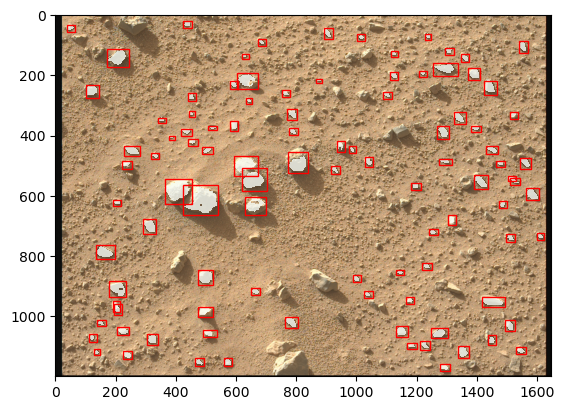

In [30]:
import matplotlib.patches as patches
# load an image
img_num = "013"
dataset_path = '../M2020_clastsurveys/ZLF_0762_0734600211_239FDR_N0374972ZCAM07114_0340LMJ01.png'
image = Image.open(dataset_path)
image = np.array(image)
# convert to torch tensor
image = torch.from_numpy(image).permute(2, 0, 1).float() / 255  # Normalize to [0,1]

# add a batch dimension
image = image.unsqueeze(0)

# define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# ensure the image is on the correct device
image = image.to(device)

# switch the model to evaluation mode
model.eval()
model = model.to(device)

# perform prediction
with torch.no_grad():
    prediction = model(image)

# Convert tensor image back to PIL image for displaying
image_disp = image.squeeze().cpu().numpy()
image_disp = Image.fromarray((image_disp.transpose((1, 2, 0)) * 255).astype(np.uint8))

fig, ax = plt.subplots(1)
ax.imshow(image_disp)

boxes = prediction[0]['boxes']
masks = prediction[0]['masks']

for box, mask in zip(boxes, masks):
    box = box.cpu().numpy()
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

     # Display mask
    mask = mask[0].cpu().numpy()
    mask = mask > 0.5  # Create a boolean mask where predictions are greater than 0.5
    ax.imshow(np.where(mask, mask, np.nan), alpha=0.8, cmap='Greens')  # Display only non-zero mask areas in bright green

plt.show()